In [1]:
import time
import numpy as np
from numba import typed
from pyloki.simulation.pulse import PulseSignalConfig
from pyloki.config import PulsarSearchConfig
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import Periodogram
from pyloki.detection import scoring
from pyloki.utils import np_utils
from matplotlib import pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


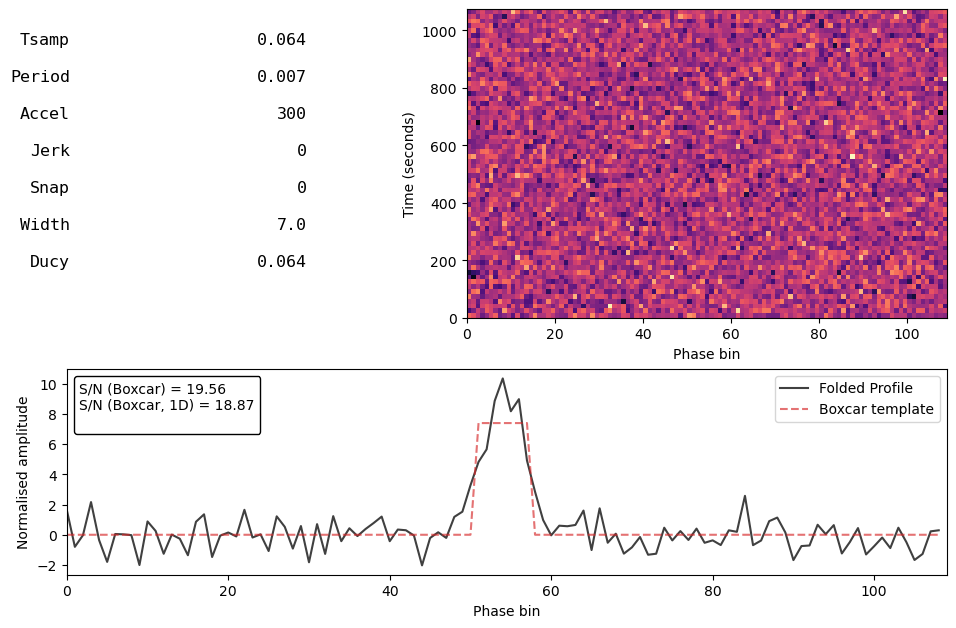

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 300
nsamps = 2**24
mod_kwargs = {"acc": accel}

cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=20, ducy=0.1, mod_kwargs=mod_kwargs)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs); plt.show()

In [3]:
tol_bins = cfg.tol_bins
fold_bins = cfg.fold_bins_ideal

tol_bins = 4
fold_bins = 64
param_limits = typed.List([(200.0, 400.0), (1/0.00702, 1/0.00698)])
bseg_brute = cfg.nsamps//256
search_cfg = PulsarSearchConfig(cfg.nsamps, cfg.dt, fold_bins, tol_bins, param_limits, bseg_brute=bseg_brute)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

2024-09-10 23:48:36 INFO     - pyloki.ffa - Initializing data structure...

                    INFO     - pyloki.ffa - param steps: [3.49004355e+04 1.49260005e-02]

2024-09-10 23:48:38 INFO     - pyloki.ffa - fold dimensions: (256, 1, 54, 2, 64)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 2.578 seconds

                    INFO     - pyloki.ffa - param steps: [8.72510887e+03 7.45678525e-03]

2024-09-10 23:48:40 INFO     - pyloki.ffa - i_iter: 1, fold dims: (128, 1, 109, 2, 64)

                    INFO     - pyloki.ffa - param steps: [2.18127722e+03 3.72684081e-03]

                    INFO     - pyloki.ffa - i_iter: 2, fold dims: (64, 1, 219, 2, 64)

                    INFO     - pyloki.ffa - param steps: [5.45319304e+02 1.86303270e-03]

                    INFO     - pyloki.ffa - i_iter: 3, fold dims: (32, 1, 438, 2, 64)

                    INFO     - pyloki.ffa - param steps: [1.36329826e+02 9.31419452e-04]

                    INFO     - pyloki.ffa - i_iter: 4, fold dims: (16, 1, 876, 2, 64)

                    INFO     - pyloki.ffa - param steps: [3.40824565e+01 4.65685505e-04]

                    INFO     - pyloki.ffa - i_iter: 5, fold dims: (8, 5, 1752, 2, 64)

                    INFO     - pyloki.ffa - param steps: [8.52061413e+00 2.32836698e-04]

                    INFO     - pyloki.ffa - i_iter: 6, fold dims: (4, 23, 3506, 2, 64)

                    INFO     - pyloki.ffa - param steps: [2.13015353e+00 1.16416835e-04]

2024-09-10 23:48:41 INFO     - pyloki.ffa - i_iter: 7, fold dims: (2, 93, 7012, 2, 64)

                    INFO     - pyloki.ffa - param steps: [5.32538383e-01 5.82080393e-05]

2024-09-10 23:48:51 INFO     - pyloki.ffa - i_iter: 8, fold dims: (1, 375, 14024, 2, 64)

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 13.102 seconds

In [4]:
folds = dyp.get_fold_norm()
widths = scoring.generate_box_width_trials(dyp.nbins, ducy_max=0.2, spacing_factor=1)
snrs = scoring.boxcar_snr(folds, widths)
idx_freq = np_utils.find_nearest_sorted_idx(dyp.param_arr[-1], cfg.freq)
idx_acc = np_utils.find_nearest_sorted_idx(dyp.param_arr[-2], cfg.mod_kwargs["acc"])
true_params_idx = (idx_acc, idx_freq)
print(f"True param indices: {true_params_idx}")

pgram = Periodogram(params={"width": widths, "freq": dyp.param_arr[-1], "accel": dyp.param_arr[-2]}, 
                    snrs=snrs, tobs=tim_data.tobs)
print(f"Best param indices: {pgram.find_best_indices()}")
print(pgram.get_summary())

True param indices: (187, 6991)
Best param indices: (np.int64(186), np.int64(6991), np.int64(6))
Best S/N: 16.85
Best Period: 0.007000001324177091
Best accel: 299.468085106383
Best freq: 142.8571158331257
Best width: 7


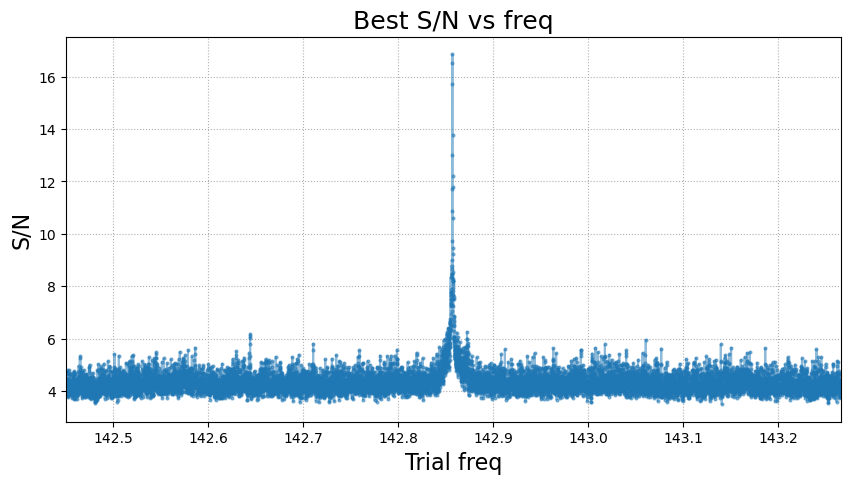

In [5]:
fig = pgram.plot_1d("freq", figsize=(10, 5)); plt.show()

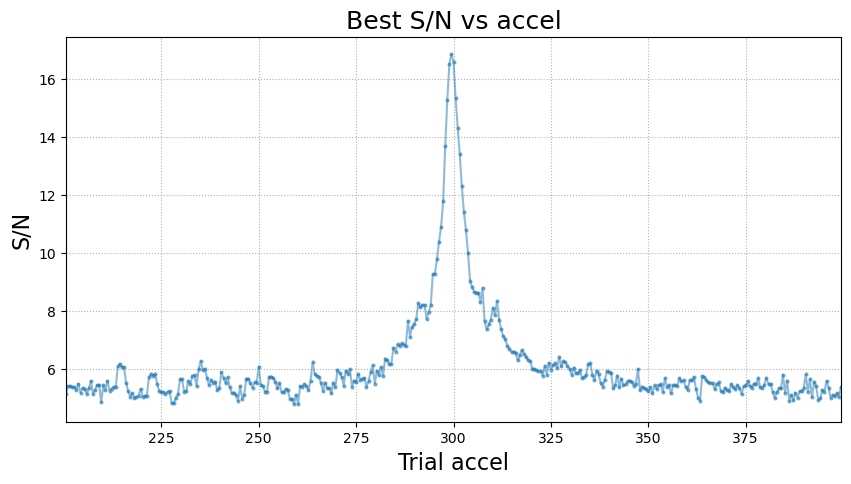

In [6]:
fig = pgram.plot_1d("accel", figsize=(10, 5)); plt.show()

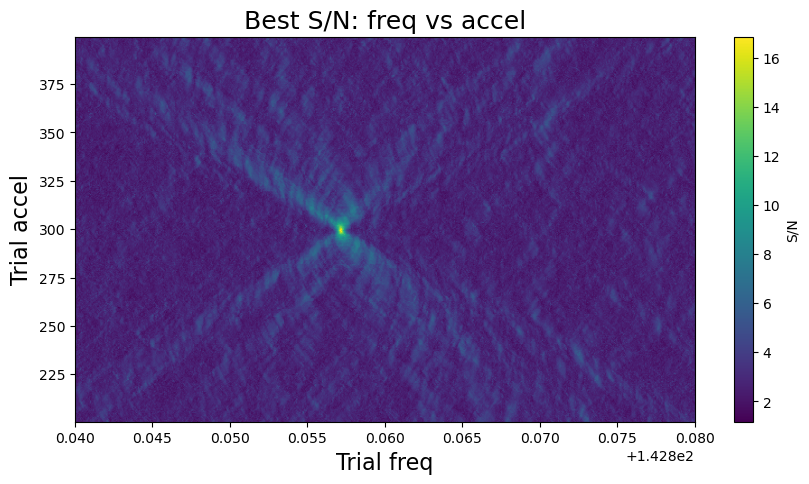

In [7]:
fig = pgram.plot_2d("freq", "accel", x_lim=(142.84, 142.88), figsize=(10, 5)); plt.show()